<a href="https://colab.research.google.com/github/shreyamali01/CS203_Lab07/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Step 1 : Dataset Preparation**

Installing Required Libraries

In [1]:
pip install scikit-learn -q

In [2]:
pip install transformers -q

In [148]:
pip install tensorboard==2.18.0

Importing Required Libraries

In [68]:
#importing required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModel
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Loading Dataset 1

In [69]:
#loading train and test datset 1 from URL
url_train = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
train_data = pd.read_csv(url_train, delimiter='\t', header=None)
url_test = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
test_data = pd.read_csv(url_test, delimiter='\t', header=None)

#adding columns for clarity
train_data.columns = ['sentences', 'labels']
test_data.columns = ['sentences', 'labels']

#printing first few rows of the dataset
print(train_data.head())

                                           sentences  labels
0  a stirring , funny and finally transporting re...       1
1  apparently reassembled from the cutting room f...       0
2  they presume their audience wo n't sit still f...       0
3  this is a visually stunning rumination on love...       1
4  jonathan parker 's bartleby should have been t...       1


Printing Dataset 1 Statistics

In [70]:
print(f"training set size: {len(train_data)}")
print(f"test set size: {len(test_data)}")

training set size: 6920
test set size: 1821


Splitting Dataset 1 into Training and Validation Sets

In [71]:
#splitting dataset 1 into train set 80% and validation set 20%
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

#checking sizes of the splits
print(f"training set size: {len(train_data)}")
print(f"validation set size: {len(val_data)}")

training set size: 5536
validation set size: 1384


In [72]:
#displaying the first few rows of training and validation sets
print("\nTraining set:")
print(train_data.head())

print("\nValidation set:")
print(val_data.head())


Training set:
                                              sentences  labels
4457  graphic sex may be what 's attracting audience...       1
2471               perhaps the grossest movie ever made       0
26    the film is moody , oozing , chilling and hear...       1
4828  watching the chemistry between freeman and jud...       1
63    the wonderfully lush morvern callar is pure pu...       1

Validation set:
                                              sentences  labels
468                                 overly melodramatic       0
1956  lrb westbrook rrb makes a wonderful subject fo...       1
800    mama africa pretty much delivers on that promise       1
6474                                sad nonsense , this       0
2389  easily the most thoughtful fictional examinati...       1


Loading IMDB Dataset (Dataset 2)

In [73]:
#loading IMDB Dataset (Dataset 2)
url_imdb = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_data = pd.read_csv(url_imdb)

#printing first few rows of the dataset
print(imdb_data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Preprocessing IMDB Dataset (Dataset 2)

In [50]:
#renaming the columns
imdb_data.columns = ['sentences', 'labels']

#converting sentiment labels to binary
imdb_data['labels'] = imdb_data['labels'].map({'positive': 1, 'negative': 0})

#splitting the IMDB dataset training and validation sets
imdb_train, imdb_val = train_test_split(imdb_data, test_size=0.2, random_state=42, stratify=imdb_data['labels'])

#checking the size of the splits
print(f"IMDB training set size: {len(imdb_train)}")
print(f"IMDB validation set size: {len(imdb_val)}")

IMDB training set size: 40000
IMDB validation set size: 10000


In [74]:
#displaying the first few rows of training and validation sets
print("\nTraining set:")
print(imdb_train.head())

print("\nValidation set:")
print(imdb_val.head())


Training set:
                                               sentences  labels
47808  I caught this little gem totally by accident b...       1
20154  I can't believe that I let myself into this mo...       0
43069  *spoiler alert!* it just gets to me the nerve ...       0
19413  If there's one thing I've learnt from watching...       0
13673  I remember when this was in theaters, reviews ...       0

Validation set:
                                               sentences  labels
18870  Yes, MTV there really is a way to market Daria...       0
39791  The story of the bride fair is an amusing and ...       0
30381  A team varied between Scully and Mulder, two o...       1
42294  This was a popular movie probably because of t...       0
33480  This movie made me so angry!! Here I am thinki...       0


### **Step 2 : Constructing a Multi-Layer Preceptron Model**

Defining the MLP Model

In [75]:
#deining the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.3):
        super(MLP, self).__init__()

        #input layer to first hidden layer
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        #adding hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

            #output layer
            self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

            #activation function
            self.activation = nn.ReLU()

            #dropout layer
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
            #applying dropout after activation
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

Defining an automated function

In [94]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Model for BOW features (1000 features)

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bow = MLP(
    input_size=10000,
    hidden_sizes=[512, 256, 128, 64],
    output_size=2,
    dropout_prob=0.3
).to(device)

Model Summary

In [122]:
print("BoW Model Architecture:")
print(model_bow)

BoW Model Architecture:
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [97]:
#counting and printing the number of trainable parameters
num_params = count_parameters(model_bow)
print(f"number of trainable parameters: {num_params}")

number of trainable parameters: 5293122


Model for Embedding (768 features)

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_embedding = MLP(
    input_size=768,
    hidden_sizes=[512, 256, 128, 64],
    output_size=2,
    dropout_prob=0.3
).to(device)

Model Summary

In [145]:
print("Embedding Model Architecture:")
print(model_embedding)

Embedding Model Architecture:
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [116]:
#counting and printing the number of trainable parameters
num_params = count_parameters(model_embedding)
print(f"number of trainable parameters: {num_params}")

number of trainable parameters: 566338


### **Step 3 : Implementing Bag of Words**

In [106]:
#initializing the countvectorizer with max_features = 10000
vectorizer = CountVectorizer(max_features=10000)

#fitting the vectorizer on the training data
X_train_bow = vectorizer.fit_transform(train_data['sentences'])

#transforming the validation and the test data
X_val_bow = vectorizer.transform(val_data['sentences'])
X_test_bow = vectorizer.transform(test_data['sentences'])

#converting the labels to numpy arrays
y_train = train_data['labels'].values
y_val = val_data['labels'].values
y_test = test_data['labels'].values

#checking the shape of the BoW features
print(f"training data shape: {X_train_bow.shape}")
print(f"validation data shape: {X_val_bow.shape}")
print(f"test data shape: {X_test_bow.shape}")

training data shape: (5536, 10000)
validation data shape: (1384, 10000)
test data shape: (1821, 10000)


Converting BoW Features to PyTorch Tensors

In [107]:
#converting BoW features to PyTorch tensors
X_train_bow = torch.tensor(X_train_bow.toarray(), dtype=torch.float32)
X_val_bow = torch.tensor(X_val_bow.toarray(), dtype=torch.float32)
X_test_bow = torch.tensor(X_test_bow.toarray(), dtype=torch.float32)

#converting lables to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#checking the shape of the tensors
print(f"training data tensor shape: {X_train_bow.shape}")
print(f"validation data tensor shape: {X_val_bow.shape}")
print(f"test data tensor shape: {X_test_bow.shape}")

training data tensor shape: torch.Size([5536, 10000])
validation data tensor shape: torch.Size([1384, 10000])
test data tensor shape: torch.Size([1821, 10000])


Verifying the Tensors


In [108]:
#printing the first few rows of the training data
print("first few rows of training data:")
print(X_train_bow[:5])
print("\n")

#printing the corresponding labels
print("corresponding labels:")
print(y_train[:5])

first few rows of training data:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


corresponding labels:
tensor([1, 0, 1, 1, 1])


Creating DataLoaders

In [109]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

#training dataloader
train_dataset_bow = TensorDataset(X_train_bow, y_train)
train_loader_bow = DataLoader(train_dataset_bow, batch_size=batch_size, shuffle=True)

#validation dataloader
val_dataset_bow = TensorDataset(X_val_bow, y_val)
val_loader_bow = DataLoader(val_dataset_bow, batch_size=batch_size)

#test dataloader
test_dataset_bow = TensorDataset(X_test_bow, y_test)
test_loader_bow = DataLoader(test_dataset_bow, batch_size=batch_size)

### **Step 4 : Constructing a function to use Embedding on the same model**

In [126]:
class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #loading the tokenizer and model for the specified transformer model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)

        if torch.cuda.is_available():
            self.model = self.model.half()

        self.model.eval()
        #getting the embedding size from the model's configuration
        self.embedding_size = self.model.config.hidden_size


    def get_embeddings(self, texts, max_samples=200, batch_size=16):
        #list to store batch embeddings
        embeddings = []
        texts = texts[:max_samples]

        with torch.no_grad():
          if torch.cuda.is_available():
              with torch.amp.autocast(device_type='cuda'):
                  return self._process_batches(texts, batch_size)
          else:
              return self._process_batches(texts, batch_size)

    def _process_batches(self, texts, batch_size):
      embeddings = []
      for i in range(0, len(texts), batch_size):
          batch = texts[i:i+batch_size]
          inputs = self.tokenizer(
              batch,
              padding=True,
              truncation=True,
              max_length=128,
              return_tensors='pt'
          ).to(self.device)

          outputs = self.model(**inputs)
          batch_embeddings = outputs.last_hidden_state[:, 0, :]

          #converting to float32 for cpu compatibility
          embeddings.append(batch_embeddings.cpu().float())

      return torch.cat(embeddings, dim=0)

Initializing the embedder

In [127]:
embedder = TextEmbedder()

Function to process the embeddings

In [128]:
def process_embeddings(data, embedder):
    texts = data['sentences'].tolist()
    embeddings = embedder.get_embeddings(texts)
    return TensorDataset(
        embeddings,  # Already converted to float32
        torch.tensor(data['labels'].values[:len(embeddings)], dtype=torch.long)
    )

Creating Dataset and DataLoaders

In [129]:
#creating datasets
train_dataset_emb = process_embeddings(train_data, embedder)
val_dataset_emb = process_embeddings(val_data, embedder)
test_dataset_emb = process_embeddings(test_data, embedder)

#creating dataloaders
train_loader_emb = DataLoader(train_dataset_emb, batch_size=16, shuffle=True)
val_loader_emb = DataLoader(val_dataset_emb, batch_size=16)

Printing first layer weight shape for both the models

In [124]:
print("\nBoW model first layer weight shape:", model_bow.layers[0].weight.shape)
print("Embed model first layer weight shape:", model_embedding.layers[0].weight.shape)


BoW model first layer weight shape: torch.Size([512, 10000])
Embed model first layer weight shape: torch.Size([512, 768])


### **Step 5: Train the model and create best performing model**

In [132]:
def train_model(model, train_loader, val_loader, name='model'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    writer = SummaryWriter(f'runs/{name}')

    #logging hyperparameters
    writer.add_hparams(
        {'lr': 0.001, 'batch_size': train_loader.batch_size, 'model': name},
        {'hparam/val_acc': 0}
    )

    best_acc = 0
    for epoch in range(10):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        #validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_correct += (torch.argmax(outputs, 1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        #saving compressed checkpoint
        if val_acc > best_acc:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc
            }
            torch.save(checkpoint, f'checkpoint_{name}.pt')
            best_acc = val_acc

        print(f'Epoch {epoch+1}: Val Acc: {val_acc:.4f}')

    writer.close()
    return model

Training Both the Models

In [133]:
print("\nTraining BOW Model:")
model_bow = train_model(model_bow, train_loader_bow, val_loader_bow, 'bow')

print("\nTraining Embedding Model:")
model_emb = train_model(model_embedding, train_loader_emb, val_loader_emb, 'emb')


Training BOW Model:
Epoch 1: Val Acc: 0.8078
Epoch 2: Val Acc: 0.7912
Epoch 3: Val Acc: 0.8006
Epoch 4: Val Acc: 0.7999
Epoch 5: Val Acc: 0.8006
Epoch 6: Val Acc: 0.7919
Epoch 7: Val Acc: 0.7919
Epoch 8: Val Acc: 0.7919
Epoch 9: Val Acc: 0.7977
Epoch 10: Val Acc: 0.7962

Training Embedding Model:
Epoch 1: Val Acc: 0.5750
Epoch 2: Val Acc: 0.5750
Epoch 3: Val Acc: 0.6150
Epoch 4: Val Acc: 0.7650
Epoch 5: Val Acc: 0.8000
Epoch 6: Val Acc: 0.8100
Epoch 7: Val Acc: 0.8050
Epoch 8: Val Acc: 0.7800
Epoch 9: Val Acc: 0.8200
Epoch 10: Val Acc: 0.7950


In [135]:
!tensorboard --logdir=runs

2025-03-15 17:09:53.687457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742058593.740570   78869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742058593.759141   78869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 17:10:03.145323: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, u

### Step 6 : Using checkpoint and training on IMDB data

(a) For embedded model

In [85]:
checkpoint = torch.load('best_emb.pt')
model_emb.load_state_dict(checkpoint['model_state_dict'])

#initializing optimizer with smaller learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emb.parameters(), lr=0.0001)

In [86]:
#processing IMDB dataset using embeddings
train_dataset_imdb = process_embeddings(imdb_train, embedder)
val_dataset_imdb = process_embeddings(imdb_val, embedder)

#creating IMDB dataloaders
train_loader_imdb = DataLoader(train_dataset_imdb, batch_size=16, shuffle=True)
val_loader_imdb = DataLoader(val_dataset_imdb, batch_size=16)

In [87]:
#resuming training on IMDB dataset
print("\nResuming training on IMDB dataset:")
model_emb = train_model(model_emb, train_loader_imdb, val_loader_imdb, 'emb_imdb')


Resuming training on IMDB dataset:
Epoch 1: Val Acc: 0.8100
Epoch 2: Val Acc: 0.8050
Epoch 3: Val Acc: 0.7800
Epoch 4: Val Acc: 0.7400
Epoch 5: Val Acc: 0.7800
Epoch 6: Val Acc: 0.7700
Epoch 7: Val Acc: 0.6800
Epoch 8: Val Acc: 0.7600
Epoch 9: Val Acc: 0.7900
Epoch 10: Val Acc: 0.7650


(b) For BOW model

In [139]:
#loading BoW checkpoint from Dataset 1 training
checkpoint = torch.load('best_bow.pt')
model_bow.load_state_dict(checkpoint['model_state_dict'])

#initializing optimizer with smaller learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bow.parameters(), lr=0.0001)  # Smaller LR

#processing IMDB dataset using the BoW vectorizer from Step 3
def process_bow_data(data, vectorizer):
    texts = data['sentences'].tolist()
    features = vectorizer.transform(texts).toarray()
    labels = data['labels'].values
    return TensorDataset(
        torch.FloatTensor(features),
        torch.LongTensor(labels)
    )

#creating IMDB datasets
train_dataset_imdb_bow = process_bow_data(imdb_train, vectorizer)  # Use original vectorizer
val_dataset_imdb_bow = process_bow_data(imdb_val, vectorizer)

#creating IMDB dataloaders
train_loader_imdb_bow = DataLoader(train_dataset_imdb_bow, batch_size=16, shuffle=True)
val_loader_imdb_bow = DataLoader(val_dataset_imdb_bow, batch_size=16)

In [140]:
#resuming training on IMDB dataset
print("\nResuming training on IMDB dataset (BoW):")
model_bow = train_model(model_bow, train_loader_imdb_bow, val_loader_imdb_bow, 'bow_imdb')


Resuming training on IMDB dataset (BoW):
Epoch 1: Val Acc: 0.8914
Epoch 2: Val Acc: 0.8914
Epoch 3: Val Acc: 0.8894
Epoch 4: Val Acc: 0.8773
Epoch 5: Val Acc: 0.8799


KeyboardInterrupt: 

### **Step 7 : Computing Validation Loss and Accuracy**

In [143]:
import numpy as np
def evaluate_model(model, data_loader, dataset_name="Dataset 1"):
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    print(f"Evaluation on {dataset_name}:")
    print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return avg_loss, accuracy, all_preds, all_labels

#evaluating on dataset 1
#bow model
print("BoW Model:")
loss_d1_bow, acc_d1_bow, _, _ = evaluate_model(model_bow, val_loader_bow, "Dataset 1")

#BERT model
print("\nBERT Model:")
loss_d1_bert, acc_d1_bert, _, _ = evaluate_model(model_emb, val_loader_emb, "Dataset 1")

#evaluating on IMDB dataset

#bow model
print("\nBoW Model (IMDB):")
loss_imdb_bow, acc_imdb_bow, _, _ = evaluate_model(model_bow, val_loader_imdb_bow, "IMDB")

#BERT model
print("\nBERT Model (IMDB):")
loss_imdb_bert, acc_imdb_bert, _, _ = evaluate_model(model_emb, val_loader_imdb, "IMDB")

BoW Model:
Evaluation on Dataset 1:
Loss: 1.3438, Accuracy: 0.7840

BERT Model:
Evaluation on Dataset 1:
Loss: 0.5565, Accuracy: 0.8200

BoW Model (IMDB):
Evaluation on IMDB:
Loss: 0.9395, Accuracy: 0.8884

BERT Model (IMDB):
Evaluation on IMDB:
Loss: 0.7411, Accuracy: 0.7500


In [149]:
!tensorboard --logdir=runs

2025-03-15 18:11:51.406407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742062311.463577   93740 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742062311.480186   93740 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 18:12:00.507423: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, u

In [150]:
print(f"Criterion: {criterion} \n")
print(f"Optimizer: {optimizer} \n")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}\n")
print(f"Batch Size: {train_loader_emb.batch_size}\n")

Criterion: CrossEntropyLoss() 

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
) 

Learning Rate: 0.0001

Batch Size: 16



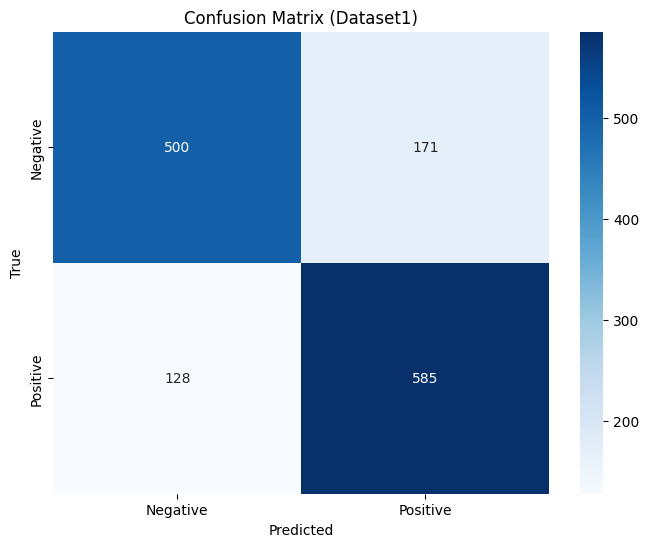

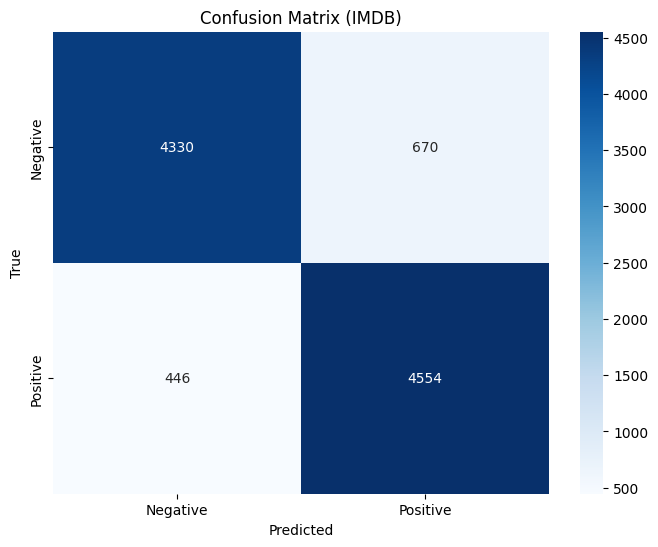

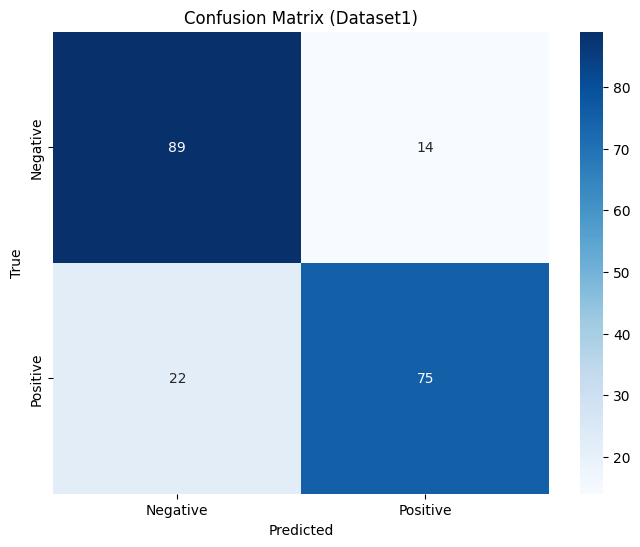

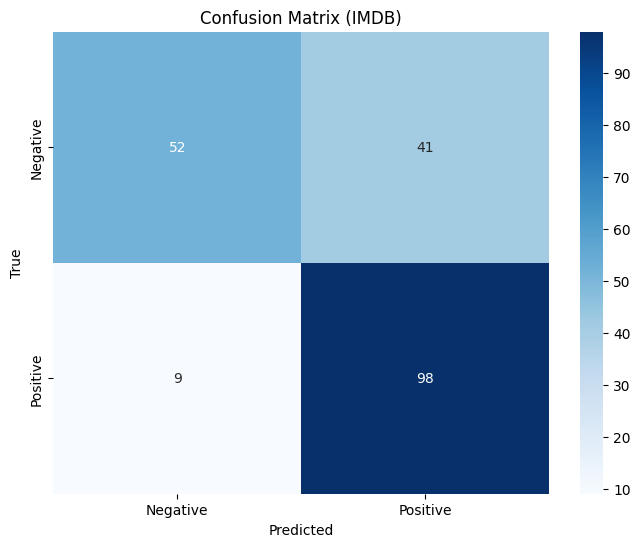

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(true_labels, predicted_labels, classes=['Negative', 'Positive'],
                          title='Confusion Matrix', filename='confusion_matrix.png'):
    """
    Plots and saves a confusion matrix using seaborn/matplotlib

    Args:
        true_labels: Array of ground truth labels
        predicted_labels: Array of model predictions
        classes: List of class names (default: ['Negative', 'Positive'])
        title: Title for the plot
        filename: Name to save the plot as
    """
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Example usage with your model and DataLoader
def generate_all_confusion_matrices(model, loaders):
    """
    Generates confusion matrices for multiple datasets

    Args:
        model: Trained PyTorch model
        loaders: Dict of DataLoaders {'name': loader}
    """
    model.eval()

    for name, loader in loaders.items():
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        plot_confusion_matrix(all_labels, all_preds,
                             title=f'Confusion Matrix ({name})',
                             filename=f'confusion_matrix_{name}.png')

# for BoW model
generate_all_confusion_matrices(model_bow, {
    'Dataset1': val_loader_bow,
    'IMDB': val_loader_imdb_bow
})

# for BERT model
generate_all_confusion_matrices(model_emb, {
    'Dataset1': val_loader_emb,
    'IMDB': val_loader_imdb
})

In [156]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, model_name="Model", save_path="loss_curves.png"):

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', linestyle='--')

    plt.title(f"{model_name} - Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Modified training function to track losses
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss/len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss/len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

    # Plot after training completes
    plot_loss_curves(train_losses, val_losses,
                    model_name=model.__class__.__name__,
                    save_path=f"{model.__class__.__name__}_loss_curves.png")

    return model